This notebook is used as the basis of this article at medium. It seeks to gain insight on the Kolmogorov-Smirnov goodness of fit test and its limitations when we are estimating the distribution parameters from the data.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import beta, kstest, lognorm, norm
from statsmodels.stats.diagnostic import lilliefors
from sklearn.datasets import load_iris
from ecdf import EmpiricalCDF
from montecarlo_kstest import MontecarloKSTest

In [2]:
seed = 75  # for making the notebook reproducible

def seeds_generator(seed, n_samples):
    lower = np.random.RandomState(seed).randint(0, 1e4)
    return (i for i in np.arange(lower, lower + n_samples))

# Table contents

 - [Kolmogorov-Smirnov test visualized](#Kolmogorov-Smirnov-test-visualized)
 - [Problems with KS Test and the Lilliefors test](#Problems-with-KS-Test-and-the-Lilliefors-test)
 - [Beyond Lilliefors: other distributions than normal and exponential](#Beyond-Lilliefors:-other-distributions-than-normal-and-exponential)
 - [Real-world data](#Real-world-data)
   - [Fitting a Normal distribution](#Fitting-a-Normal-distribution)
   - [Fitting a log-normal distribution](#Fitting-a-log-normal-distribution)
 - [Conclusion](#Conclusion)
 - [References and further reading](#References-and-further-reading)

# Kolmogorov-Smirnov test visualized

Let's start by gaining insight on the Kolmogorov-Smirnov test does by visualizing the statistic used in the test. We are simulating _n_ samples from a normal distribution, computing the empirical cumulative distribution from the sample and calculate the maximum difference with the normal distribution cumulative distribution function (CDF).

In [3]:
n = 60
nx = norm(loc=0, scale=1).rvs(size=n, random_state=seed)
ecdf = EmpiricalCDF(nx)

cdf_x, cdf_y = ecdf.staircase_arrays()

ks_statistic = np.abs(cdf_y - norm.cdf(cdf_x))
ks_statistic_idx, ks_statistic = (np.argmax(ks_statistic), np.max(ks_statistic))

Text(0, 0.5, 'Cumulative probability')

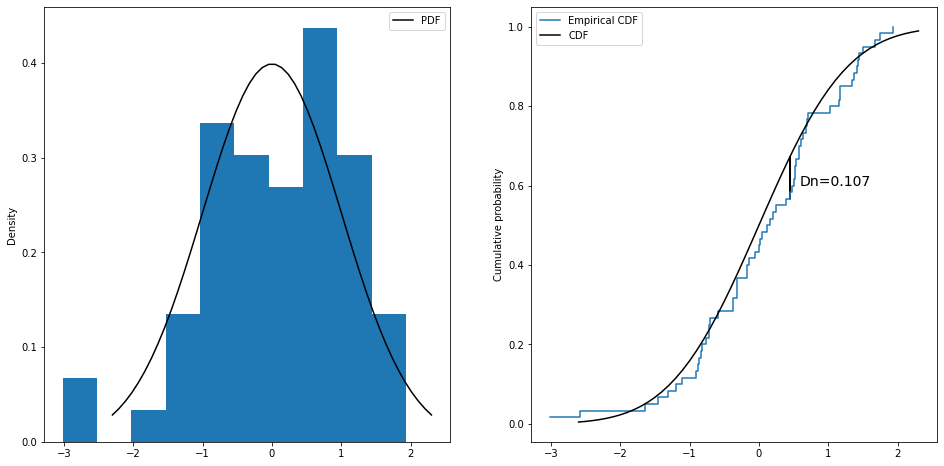

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(16,8))
ax[0].hist(nx, density=True);
ax[0].plot(np.linspace(-2.3, 2.3), norm.pdf(np.linspace(-2.3, 2.3)), label="PDF", color='k')
ax[0].set_ylabel("Density")
ax[0].legend()

ax[1].step(ecdf.x, ecdf.y, where="post", label="Empirical CDF")
ax[1].plot(np.linspace(-2.6, 2.3), norm.cdf(np.linspace(-2.6, 2.3)), label="CDF", color='k')
ax[1].arrow(cdf_x[ks_statistic_idx], cdf_y[ks_statistic_idx],
            0, norm.cdf(cdf_x[ks_statistic_idx]) - cdf_y[ks_statistic_idx],
            linewidth=1.5, length_includes_head=True)
ax[1].text(cdf_x[ks_statistic_idx] * 1.3,
           cdf_y[ks_statistic_idx] + (norm.cdf(cdf_x[ks_statistic_idx]) - cdf_y[ks_statistic_idx])*.3,
          f"Dn={ks_statistic:.3f}", size=14)
ax[1].legend()
ax[1].set_ylabel("Cumulative probability")

(left) PDF of a Normal(0, 1) and a 60 size sample from it and (right) the empirical Cumulative Density Function (eCDF) of the sample in blue, the Cumulative Distribution Function (CDF) of the Normal(0, 1) in black and the Dn statistic of the Kolmogorov-Smirnov test.

We can see that scipy implementation of test returns the same statistic value below:

In [5]:
kstest(nx, "norm")

KstestResult(statistic=0.10712756309829974, pvalue=0.4646185603463846)

# Problems with KS Test and the Lilliefors test

The Kolmogorov-Smirnov test assumes that the distribution under study is fully specified (kind of distribution plus parameters). However, if we estimate the parameters from the sample the KS test p-values are no longer reliable. If that is the case, we need to have a look at modifications of the KS test, like the Lilliefors test.

The Lilliefors test computes the same statistic as the KS test but its p-values are corrected for the case where distribution parameters are being estimated from the data. Unfortunately, Lilliefors test is only available for the Normal and Exponential distributions.

If we aim to perform the KS test for a distribution fitted from the data and other than Normal or exponential, we can perform a Montecarlo simulation as in the MontecarloKSTest class, where the Dn statistic is computed by the p-values are estimated by Montecarlo simulation.


To see all of this in action, let's imagine the following example: we are studying a process that we expect to be normally distributed, which in reality behaves as a mixture of Gaussians:
 - With 75% it comes from a $\mathcal{N}(0, 1)$
 - It has two noisy modes at $\mathcal{N}(1.2, .7)$ and $\mathcal{N}(-1.5, .55)$ with 12.5% probability eachl

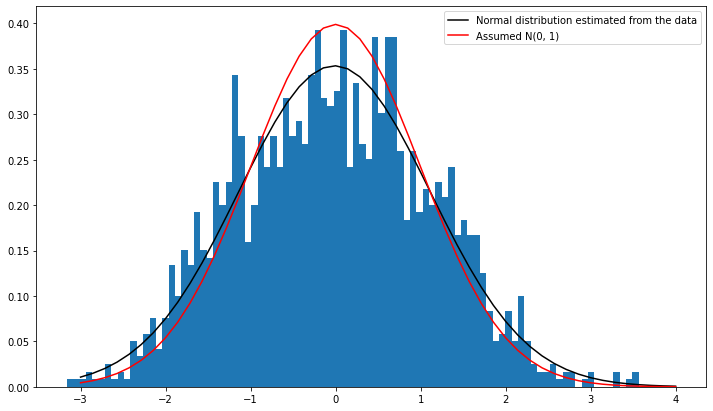

In [6]:
n = 1600
n1 = 1200
n2 = 200
n3 = n - n1 - n2

sx = np.hstack((norm(loc=0, scale=1).rvs(n1, random_state=seed),
                norm(loc=1.2, scale=.7).rvs(n2, random_state=seed),
                norm(loc=-1.5, scale=.55).rvs(n3, random_state=seed)))

fig, ax = plt.subplots(figsize=(12, 7))
ax.hist(sx, density=True, bins=90)
ax.plot(np.linspace(-3, 4), norm(*norm.fit(sx)).pdf(np.linspace(-3, 4)), 'k',
         label="Normal distribution estimated from the data")
ax.plot(np.linspace(-3, 4), norm(0, 1).pdf(np.linspace(-3, 4)), 'r',
         label="Assumed N(0, 1)")
ax.legend()

If we perform the KS test with our fully specified assumed distributions we get a p-value small enough to correctly reject our hypothesis of $\mathcal{N}(0, 1)$ as it is show below:

In [7]:
kstest(sx, 'norm', args=(0, 1))

KstestResult(statistic=0.06213483843010406, pvalue=8.198267376029681e-06)

What happens if we just assume that the distribution is normal and we fit its parameters from the data?

In [8]:
ks_statistic, ks_pvalue = kstest(sx, 'norm', args=norm.fit(sx))
lilliefors_statistic, lilliefors_pvalue = lilliefors(sx, dist="norm")

In [9]:
montecarlo_samples = 5000
montecarlo_kstest = MontecarloKSTest(montecarlo_samples)
montecarlo_statistic, montcarlo_pvalue = montecarlo_kstest.test(sx, norm,
                                                                seeds_generator(seed, montecarlo_samples))

In [10]:
pd.DataFrame(np.array([[ks_statistic, ks_pvalue],
                       [lilliefors_statistic, lilliefors_pvalue],
                       [montecarlo_statistic, montcarlo_pvalue]]),
             index=["KS test", "Lilliefors test", "Montecarlo simulation"], columns=["statistic", "pvalue"])

,statistic,pvalue
KS test,0.029913,0.111869
Lilliefors test,0.029837,0.002003
Montecarlo simulation,0.029913,0.002000


We can see how the KS test has a quite larger p-value than the one estimated by both Lilliefors and Montecarlo simulation, which account for the fact of estimating the distribution parameters from the data sample.

# Beyond Lilliefors: other distributions than normal and exponential

In this section, we will have a look at an example with distributions other than normal and exponential, where Lilliefors test does not apply. We will simulate samples from a beta distribution and test the results of the goodness of fit tests for a log-normal distribution fitted from the data.

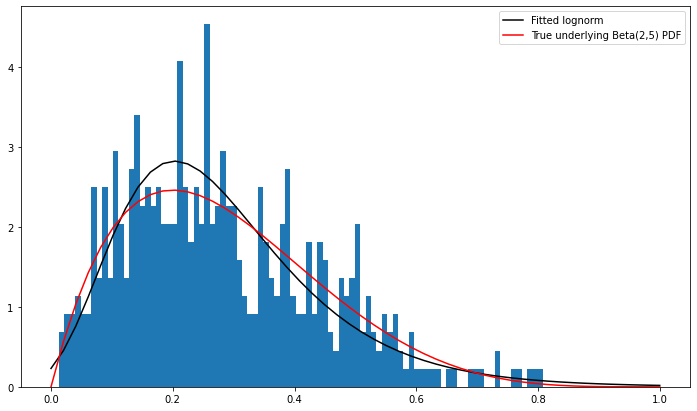

In [11]:
n = 500
sx = beta(2, 5).rvs(n, random_state=seed)

fig, ax = plt.subplots(figsize=(12, 7))
ax.hist(sx, density=True, bins=90)
ax.plot(np.linspace(0, 1), lognorm(*lognorm.fit(sx)).pdf(np.linspace(0, 1)), 'k', label="Fitted lognorm")
ax.plot(np.linspace(0, 1), beta(2, 5).pdf(np.linspace(0, 1)), 'r', label="True underlying Beta(2,5) PDF")
ax.legend()

In [12]:
ks_beta_statistic, ks_beta_pvalue = kstest(sx, "beta", args=beta.fit(sx))
ks_beta_pvalue

0.961545796581698

As it is expected we get a very large p-value when testing against a beta distribution

In [13]:
ks_lognorm_statistic, ks_lognorm_pvalue = kstest(sx, "lognorm", args=lognorm.fit(sx))
ks_lognorm_pvalue

0.3878621409897265

What it is a little bit more concerning is that for the log-normal we also get a big p-value, when we know that is not the case.

In [14]:
montecarlo_samples = 1000
montecarlo_kstest = MontecarloKSTest(montecarlo_samples)
montecarlo_statistic, montecarlo_pvalue = montecarlo_kstest.test(sx, beta,
                                                                seeds_generator(seed, montecarlo_samples))

/usr/local/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:639: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


In [15]:
montecarlo_pvalue

0.77

With our Montecarlo simulation, we see that the p-value for the Beta distribution fitted from the data is also quite large, as expected

In [16]:
montecarlo_samples = 1000
montecarlo_kstest = MontecarloKSTest(montecarlo_samples)
montecarlo_statistic, montecarlo_pvalue = montecarlo_kstest.test(sx, lognorm,
                                                                seeds_generator(seed, montecarlo_samples))

In [17]:
montecarlo_pvalue

0.017

Now, for the fitted log-normal, Montecarlo simulation outputs a small p-value, in contrast with the normal K-S test. This is an example on the effect over the p-values of using the KS test wrongly when fitting distribution parameters from the data.

# Real-world data

Finally, let's see a real-world example with the famous Iris flower dataset, specifically with the sepal length variable. Let's test the goodness of fit of both normal and log-normal distributions with estimated parameters and compare the KS test results with the Montecarlo simulation and Lilliefors test.

In [18]:
data = load_iris()['data']
x = data[:, 0]

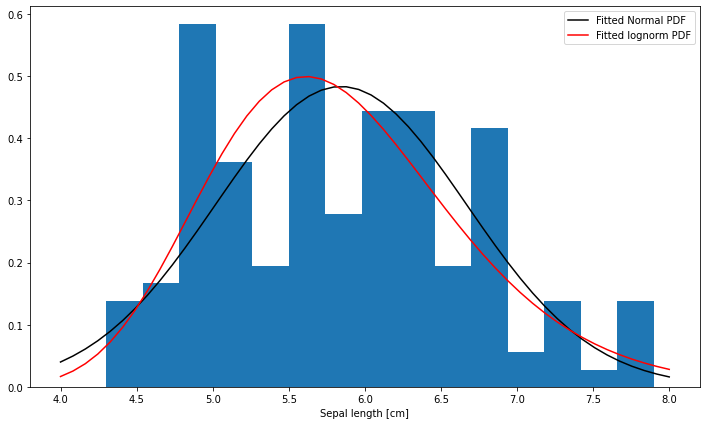

In [19]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.hist(x, density=True, bins=15);
ax.plot(np.linspace(4, 8), norm(*norm.fit(x)).pdf(np.linspace(4, 8)), 'k', label="Fitted Normal PDF")
ax.plot(np.linspace(4, 8), lognorm(*lognorm.fit(x)).pdf(np.linspace(4, 8)), 'r', label="Fitted lognorm PDF")
ax.set_xlabel("Sepal length [cm]")
ax.legend()

## Fitting a Normal distribution

In [20]:
ks_statistic, ks_pvalue = kstest(x, 'norm', args=norm.fit(x))
lilliefors_statistic, lilliefors_pvalue = lilliefors(x, dist="norm")

In [21]:
montecarlo_samples = 5000
montecarlo_kstest = MontecarloKSTest(montecarlo_samples)
montecarlo_statistic, montcarlo_pvalue = montecarlo_kstest.test(x, norm,
                                                                seeds_generator(seed, montecarlo_samples))

In [22]:
pd.DataFrame(np.array([[ks_statistic, ks_pvalue],
                       [lilliefors_statistic, lilliefors_pvalue],
                       [montecarlo_statistic, montcarlo_pvalue]]),
             index=["KS test", "Lilliefors test", "Montecarlo simulation"], columns=["statistic", "pvalue"])

,statistic,pvalue
KS test,0.089454,0.170584
Lilliefors test,0.088654,0.010291
Montecarlo simulation,0.089454,0.005000


As in the example with synthetic data, there is a big difference in p-values between the KS-test and the Montecarlo and Lilliefors test. In this case, we see a discrepancy between Lilliefors and Montecarlo simulation p-values, but probably the sources of this effect comes from:

 - Statsmodels used much more (orders of magnitude) samples for its Montecarlo simulation when building the Lilliefors p-values tables than our Montecarlo simulation.
 - Statsmodels uses an approximation for sample sizes in the Lilliefors test that are not exactly the same as the ones simulated.

## Fitting a log-normal distribution

In [23]:
ks_lognorm_statistic, ks_lognorm_pvalue = kstest(x, "lognorm", args=lognorm.fit(x))

In [24]:
montecarlo_samples = 1000
montecarlo_kstest = MontecarloKSTest(montecarlo_samples)
montecarlo_lognorm_statistic, montecarlo_lognorm_pvalue = montecarlo_kstest.test(x, lognorm,
                                                                seeds_generator(seed, montecarlo_samples))

In [25]:
pd.DataFrame(np.array([[ks_lognorm_statistic, ks_lognorm_pvalue],
                       [montecarlo_lognorm_statistic, montecarlo_lognorm_pvalue]]),
             index=["KS test", "Montecarlo simulation"], columns=["statistic", "pvalue"])

,statistic,pvalue
KS test,0.086502,0.199737
Montecarlo simulation,0.086502,0.001000


Once again the difference in p-values is very significant.

# Conclusion

In this notebook, we have had a look into the Kolmogorov-Smirnov goodness of fit test, the idea behind it and the issue that arises when we fit distribution parameters from the sample data. If the distribution under study is Normal or Exponential, we can overcome this limitation by using the Lilliefors test. For any other distribution, we must perform a Montecarlo simulation to obtain the p-values.

Other goodness of fit tests, like the Anderson-Darling test, which is more sensitive on the distribution tails, also suffers from the same problem and Montecarlo simulation must be carried out when fitting parameters from the data.

Remember that there is an associated [post](https://medium.com/@pabaldonedo/kolmogorov-smirnov-test-may-not-be-doing-what-you-think-when-parameters-are-estimated-from-the-data-2d5c3303a020) at Medium written from this notebook results that may be of your interest.

# References and further reading

Medium post:

https://medium.com/@pabaldonedo/kolmogorov-smirnov-test-may-not-be-doing-what-you-think-when-parameters-are-estimated-from-the-data-2d5c3303a020

Kolmogorov-Smirnov test explanation in detail:

https://math.mit.edu/~rmd/465/edf-ks.pdf

https://ocw.mit.edu/courses/mathematics/18-443-statistics-for-applications-fall-2006/lecture-notes/lecture14.pdf


Original Lilliefors test papers:

https://www.tandfonline.com/doi/abs/10.1080/01621459.1967.10482916

https://www.tandfonline.com/doi/abs/10.1080/01621459.1969.10500983


Paper that shows why we can build Lilliefors test p-values tables via probability integral transformation for distributions that depends only on location and scale parameters:
https://www.jstor.org/stable/2332638


Statsmodel Lilliefors simulation:

https://github.com/statsmodels/statsmodels/blob/main/statsmodels/stats/tests/results/lilliefors_critical_value_simulation.py

Stackexchange original posts that serve as starting point for this notebook

https://stats.stackexchange.com/questions/110272/a-naive-question-about-the-kolmogorov-smirnov-test

https://stats.stackexchange.com/questions/111693/simulation-of-ks-test-with-estimated-parameters

https://stats.stackexchange.com/questions/237779/how-can-one-compute-lilliefors-test-for-arbitrary-distributions

Stachexchange posts about similar behaviour for anderson-darling test:
https://stats.stackexchange.com/questions/392563/why-do-two-implementations-of-the-anderson-darling-test-produce-such-different-p/392686#392686

P-Values caveat:

http://tech.me.holycross.edu/files/2015/03/Cohen_1990.pdf

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3444174/